In [1]:
!git clone https://github.com/Miamoto/fruit-classifier

Cloning into 'fruit-classifier'...
remote: Enumerating objects: 14530, done.
remote: Counting objects: 100% (14530/14530), done.
remote: Compressing objects: 100% (14523/14523), done.
remote: Total 14530 (delta 16), reused 14490 (delta 5), pack-reused 0
Receiving objects: 100% (14530/14530), 63.11 MiB | 13.20 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Checking out files: 100% (14422/14422), done.


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 23 11:07:57 2019

@author: anama
"""


import os
import cv2
import math
import keras
import random
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import display

from keras import regularizers
from keras.applications import imagenet_utils
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, LeakyReLU, Dense, Activation, Dropout
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical


train_data_dir = "fruit-classifier/dataset/Training"
test_data_dir = "fruit-classifier/dataset/Test"
weights_filename = "weights.hdf5"


list_apples = ['Apple Crimson Snow','Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3',
               'Apple Granny Smith', 'Apple Red 1','Apple Red 2', 'Apple Red 3',
               'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2']
list_lemons = ['Lemon', 'Lemon Meyer']
list_pears  = ['Pear Abate', 'Pear Kaiser', 'Pear Monster', 'Pear Red','Pear Williams']


def process_images(lst, root_dir):
  """
  Fetch all the image path names in the subfolders of root_dir.
  """
  res = []
  for obj in lst:
    data_dir = root_dir + '/'+ obj
    for filename in os.listdir(data_dir):
      res.append(data_dir + "/" + filename)
  return res


def process_dataset(data_set):
  """
  Fetch and process all images in data_set to be used by the neural net.
  """
  # default image size
  img_height = 100
  img_width  = 100
  
  X = list()
  y = list()
  
  for img_path in data_set:
    X.append(cv2.resize(cv2.imread(img_path, cv2.IMREAD_COLOR)[:,:,::-1], dsize=(img_height, img_width),
                      interpolation=cv2.INTER_CUBIC)) #read the image
    if 'Apple' in img_path:
      y.append(0)
    elif 'Orange' in img_path:
      y.append(1)
    elif 'Lemon' in img_path:
      y.append(2)
    elif 'Pear' in img_path:
      y.append(3)
  
  return np.array(X), to_categorical(np.array(y))

Using TensorFlow backend.


In [9]:
""" Load Training Data set """

train_set = []
train_set += process_images(list_apples,train_data_dir)
train_set += process_images(['Orange'], train_data_dir)
train_set += process_images(list_lemons, train_data_dir)
train_set += process_images(list_pears, train_data_dir)
random.shuffle(train_set)

X, y = process_dataset(train_set)

print("Training Set X-Shape: " + str(X.shape))
print("Training Set y-Shape: " + str(y.shape))


"""
#30% validation set, 70% training set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=2)

print("y_train", y_train)
print("Shape of train images is:", X_train.shape)
print("Shape of validation image", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of label", y_val.shape)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

train_generator = train_datagen.flow(X_train, y_train,batch_size=nb_batch_size)
validation_generator = train_datagen.flow(X_val, y_val, batch_size=nb_batch_size)

train_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input) 
"""

Training Set X-Shape: (9365, 100, 100, 3)
Training Set y-Shape: (9365, 4)


'\n#30% validation set, 70% training set\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=2)\n\nprint("y_train", y_train)\nprint("Shape of train images is:", X_train.shape)\nprint("Shape of validation image", X_val.shape)\nprint("Shape of labels is:", y_train.shape)\nprint("Shape of label", y_val.shape)\n\ny_train = to_categorical(y_train)\ny_val = to_categorical(y_val)\n\ntrain_generator = train_datagen.flow(X_train, y_train,batch_size=nb_batch_size)\nvalidation_generator = train_datagen.flow(X_val, y_val, batch_size=nb_batch_size)\n\ntrain_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input) \n'

In [4]:
""" Load Testing Data set """

test_set = []
test_set += process_images(list_apples,test_data_dir)
test_set += process_images(['Orange'], test_data_dir)
test_set += process_images(list_lemons, test_data_dir)
test_set += process_images(list_pears, test_data_dir)
random.shuffle(test_set)

X_test, y_test = process_dataset(test_set)

print("Testing Set X-Shape: " + str(X_test.shape))
print("Testing Set y-Shape: " + str(y_test.shape))

test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)

Testing Set X-Shape: (3134, 100, 100, 3)
Testing Set y-Shape: (3134, 4)


In [5]:
""" Build the Neural Net """

base_model = MobileNet(weights='imagenet', include_top=False) # import the mobilenet model and discard the last 1000 neuron layers.

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), use_bias=True)(x) # we add dense layers so that the model can learn more complex functions

# These layers were removed to reduce the complexity of the network.
# x = LeakyReLU(alpha=0.5)(x)
# x = Dense(32,activation='relu')(x) # dense layer 2
# x = Dense(32,activation='relu')(x) # dense layer 3

predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# set the base model layers to not be trainable
for layer in base_model.layers:
  layer.trainable = False

trainable_count = 0
for layer in model.layers:
  if layer.trainable:
    trainable_count += 1

print("# Trainable Layers = " + str(trainable_count))
print("# Untrainable Layers = " + str(len(model.layers)-trainable_count))
# print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 3s 0us/step
# Trainable Layers = 3
# Untrainable Layers = 87


In [10]:
""" Compile and Train the Neural Network """

nb_epochs = 5
nb_batch_size = 128


# compile the model
model.compile(SGD(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.1, batch_size=nb_batch_size, epochs=nb_epochs)

"""
nb_steps_per_epoch = math.floor(X_train.shape[0]/nb_batch_size)
nb_validation_steps = math.floor(X_val.shape[0]/nb_batch_size)
print(nb_steps_per_epoch)
history = model.fit_generator(train_generator, steps_per_epoch=4, validation_data = validation_generator, validation_steps=2, epochs=50, verbose=2)
"""

Train on 8428 samples, validate on 937 samples
Epoch 1/5
8428/8428 [==============================] - 6s 726us/step - loss: 0.9091 - acc: 0.9128 - val_loss: 2.3187 - val_acc: 0.5635
Epoch 2/5
8428/8428 [==============================] - 5s 607us/step - loss: 0.8704 - acc: 0.9258 - val_loss: 2.3431 - val_acc: 0.5582
Epoch 3/5
8428/8428 [==============================] - 5s 607us/step - loss: 0.8392 - acc: 0.9365 - val_loss: 2.3661 - val_acc: 0.5582
Epoch 4/5
8428/8428 [==============================] - 5s 605us/step - loss: 0.8107 - acc: 0.9423 - val_loss: 2.4087 - val_acc: 0.5571
Epoch 5/5
8428/8428 [==============================] - 5s 608us/step - loss: 0.7923 - acc: 0.9485 - val_loss: 2.4301 - val_acc: 0.5550


'\nnb_steps_per_epoch = math.floor(X_train.shape[0]/nb_batch_size)\nnb_validation_steps = math.floor(X_val.shape[0]/nb_batch_size)\nprint(nb_steps_per_epoch)\nhistory = model.fit_generator(train_generator, steps_per_epoch=4, validation_data = validation_generator, validation_steps=2, epochs=50, verbose=2)\n'

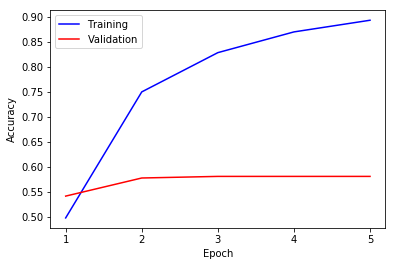

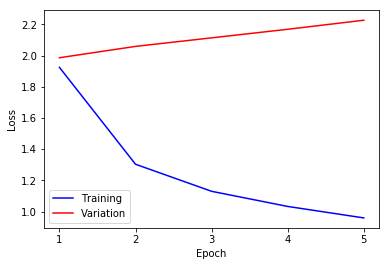

In [7]:
""" Accuracy and Loss Plots """

acc = history.history['acc']
loss = history.history['loss']

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training')
plt.plot(epochs, val_acc, 'r', label='Validation')
plt.xticks(epochs)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss, 'r', label='Variation')
plt.xticks(epochs)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
""" Compute accuracy for Test set using model prediction """
y_pred = model.predict(X_test)

correct_count = 0
for i in range(len(y_pred)):
  index = np.argmax(y_pred[i])
  if y_test[i][index] == 1:
    correct_count += 1
    
print("Accuracy = " + str(correct_count / len(y_pred)))

Accuracy = 0.5813656668793874
